# 目次

- 正例・負例件数
- そのままのデータで学習・評価
- 処理時間計測
- アンダーサンプリング
- アンダーバギング
- オーバーサンプリング
- 重み付け
- 評価指標

# ライブラリ群

In [35]:
# データ処理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

# データ準備
from sklearn.model_selection import train_test_split # データ分割
from imblearn.under_sampling import RandomUnderSampler # アンダーサンプリング
from imblearn.over_sampling import SMOTE # オーバーサンプリング（SMOTE）

# アルゴリズム
from sklearn.svm import SVC # サポートベクトルマシン
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
import lightgbm as lgb # LightGBM
from sklearn.neighbors import LocalOutlierFactor # Local Outlier Factor (LOF)

# 評価
from sklearn.metrics import confusion_matrix # 混同行列
from sklearn.model_selection import learning_curve # 学習曲線
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score # 各評価指標
from sklearn import metrics
from sklearn.metrics import roc_auc_score # AUC

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP'] # 日本語対応
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
# データ取得
creditcard = pd.read_csv("./creditcard.csv", sep=',')

In [3]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1,-0,3,1,-0,0,0,0,0,...,-0,0,-0,0,0,-0,0,-0,150,0
1,0,1,0,0,0,0,-0,-0,0,-0,...,-0,-1,0,-0,0,0,-0,0,3,0
2,1,-1,-1,2,0,-1,2,1,0,-2,...,0,1,1,-1,-0,-0,-0,-0,379,0
3,1,-1,-0,2,-1,-0,1,0,0,-1,...,-0,0,-0,-1,1,-0,0,0,124,0
4,2,-1,1,2,0,-0,0,1,-0,1,...,-0,1,-0,0,-0,1,0,0,70,0


# 正例・負例件数

In [4]:
value_counts = creditcard['Class'].value_counts()

df = pd.DataFrame()
df['ラベル'] = value_counts.index
df['件数'] = value_counts.values
ratio=[]
ratio.append((value_counts.values[0] / len(creditcard['Class']) * 100).round(decimals=2).astype('str'))
ratio.append((value_counts.values[1] / len(creditcard['Class']) * 100).round(decimals=2).astype('str'))
df['割合'] = [f'{ratio[0]}%', f'{ratio[1]}%']
print(f"全レコード数：{len(creditcard['Class'])}")
df

全レコード数：284807


,ラベル,件数,割合
0,0,284315,99.83%
1,1,492,0.17%


In [5]:
print(f'負例データは正例データの{int(value_counts.values[0]/value_counts.values[1])}倍')

負例データは正例データの577倍


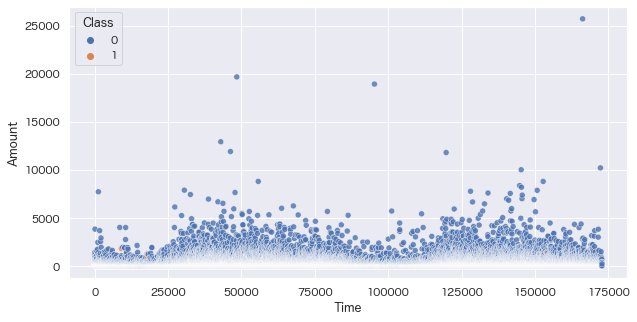

In [6]:
data = creditcard[['Time', 'Amount', 'Class']]
plt.figure(figsize=[10,5])
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8);

このままでは範囲が広く[Class=1]の値が見て取りづらい。  
[Amount=5000]以上に[Class=1]は見当たらないため、フィルタリングして再描画する。

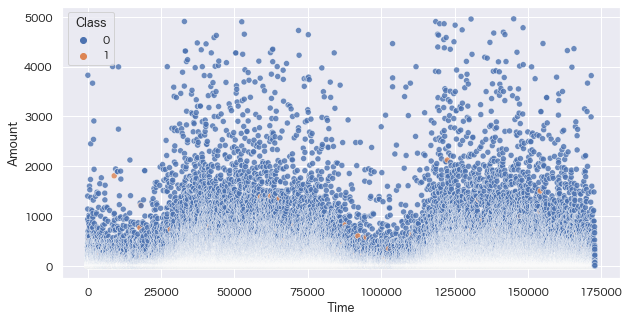

In [7]:
data = creditcard[creditcard['Amount']<5000][['Time', 'Amount', 'Class']]
plt.figure(figsize=[10,5])
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8);

まばらに[Class=1]が視認できる。

# そのままのデータで学習・評価

In [8]:
def show_confusion_matrix(predict, y_test):
    pred =  np.where(predict > 0.5, 1, 0)
    cm = confusion_matrix(y_test, pred)
    matrix = pd.DataFrame(cm)
    matrix.columns = [['予測_負例(0)', '予測_正例(1)']]
    matrix.index = [['実際_負例(0)', '実際_正例(1)']]
    return matrix

In [9]:
X = creditcard.drop('Class',axis=1)
y = creditcard['Class']

# データ分割
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ロジスティック回帰
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 混同行列
matrix = show_confusion_matrix(y_pred, y_test)
matrix

# 評価
print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('Precision = ', precision_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('Recall = ', recall_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('F1 score = ', f1_score(y_true=y_test, y_pred=y_pred).round(decimals=3))

LogisticRegression(max_iter=1000)

,予測_負例(0),予測_正例(1)
実際_負例(0),28426,9
実際_正例(1),21,25


Accuracy =  0.999
Precision =  0.735
Recall =  0.543
F1 score =  0.625


In [10]:
# 計算式
round((28426+25) / 28481, 3) # Accuracy
round(25 / (25+9), 3) # Precision
round(25 / (25+21), 3) # Recall

0.999

0.735

0.543

正解率:Accuracyは99.9%だが、再現率:Recallは61%となっており、実際に不正をした136人の内、83人(61%)しか予測できていない。

In [11]:
# サポートベクトルマシン
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# 混同行列
matrix = show_confusion_matrix(y_pred, y_test)
matrix

# 評価
print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('Precision = ', precision_score(y_true=y_test, y_pred=y_pred, zero_division=0).round(decimals=3))
print('Recall = ', recall_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
print('F1 score = ', f1_score(y_true=y_test, y_pred=y_pred).round(decimals=3))

SVC()

,予測_負例(0),予測_正例(1)
実際_負例(0),28435,0
実際_正例(1),46,0


Accuracy =  0.998
Precision =  0.0
Recall =  0.0
F1 score =  0.0


正解率:Accuracyは99%だが、再現率:Recall・適合率:Precisionは0%となっており、全て陽性と判定してしまっている。

# 処理時間の計測

In [12]:
%%time
# サポートベクトルマシン
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

CPU times: user 20.8 s, sys: 411 ms, total: 21.2 s
Wall time: 21.7 s


処理時間は若干長め

# アンダーサンプリング

In [13]:
target = 'Class'
rs=RandomUnderSampler(random_state=42)
under_sampling ,_=rs.fit_resample(creditcard, creditcard[target])

print('*'*20)
print('＜元のデータ＞')
print('0の件数：%d'%len(creditcard.query(f'{target}==0')))
print('1の件数：%d'%len(creditcard.query(f'{target}==1')))
print('*'*20)
print('＜アンダーサンプリング後のデータ＞')
print('0の件数：%d'%len(under_sampling.query(f'{target}==0')))
print('1の件数：%d'%len(under_sampling.query(f'{target}==1')));

********************
＜元のデータ＞
0の件数：284315
1の件数：492
********************
＜アンダーサンプリング後のデータ＞
0の件数：492
1の件数：492


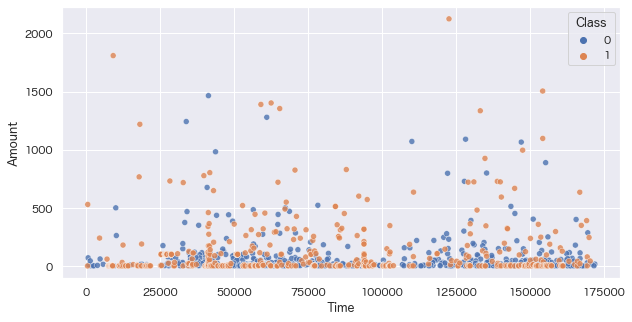

In [14]:
data = under_sampling[['Time', 'Amount', 'Class']]
plt.figure(figsize=[10,5])
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8);

正例データ(Class=1)のデータの増加を視認できる。  
Amount>3000以上のデータは、削除されている。　　

# アンダーバギング

In [15]:
# LightGBM
def lgbm_train(X_train, X_valid, y_train, y_valid):
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        num_leaves=30,
        learning_rate=0.01,
        feature_fraction=0.9,
        subsample=0.8,
        max_depth=12,
        min_data_in_leaf=12)
    model.fit(X_train, y_train)
    return model

In [16]:
# バギング
def bagging(seed):
    # アンダーサンプリング
    sampler = RandomUnderSampler(random_state=seed, replacement=True)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    model_bagging = lgbm_train(X_train2, X_valid, y_train2, y_valid)
    return model_bagging

In [17]:
# データ分割
X = creditcard.drop(columns='Class', axis=1)
y = creditcard['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# 学習
models = []
for i in tqdm(range(10)):
    models.append(bagging(i))

# 予測
y_preds = []
for m in tqdm(models):
    y_preds.append(m.predict(X_test))

# 評価
y_preds_bagging = sum(y_preds)/len(y_preds)
auc = roc_auc_score(y_test, y_preds_bagging)
print(f'AUC： {round(auc, 2)}')

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


100%|██████████| 10/10 [00:00<00:00, 24.29it/s]


AUC： 0.87


In [18]:
# 混同行列
matrix = show_confusion_matrix(y_preds_bagging, y_test)
matrix

# 評価
print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))
print('Precision = ', precision_score(y_true=y_test, y_pred=y_preds_bagging, zero_division=0).round(decimals=3))
print('Recall = ', recall_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))
print('F1 score = ', f1_score(y_true=y_test, y_pred=y_preds_bagging).round(decimals=3))

,予測_負例(0),予測_正例(1)
実際_負例(0),28435,0
実際_正例(1),12,34


Accuracy =  1.0
Precision =  1.0
Recall =  0.739
F1 score =  0.85


アンダーサンプリング＋バギングにより、正例と予測した32件は正しく予測できていることがわかる。  
ただし、実際は正例のものを負例と予測してしまっているものが12件ある為、まだまだ改善の余地はありそうである。

# オーバーサンプリング

In [19]:
# SMOTE
sm = SMOTE(random_state=42)
X = creditcard.drop(columns='Class', axis=1)
y = creditcard['Class']
X_sample, Y_sample = sm.fit_resample(X, y)

over_sampling = pd.DataFrame()
over_sampling = X_sample
over_sampling['Class'] = Y_sample

In [20]:
value_counts = over_sampling['Class'].value_counts()

df = pd.DataFrame()
df['ラベル'] = value_counts.index
df['件数'] = value_counts.values
ratio=[]
ratio.append((value_counts.values[0] / len(over_sampling['Class']) * 100).round(decimals=2).astype('str'))
ratio.append((value_counts.values[1] / len(over_sampling['Class']) * 100).round(decimals=2).astype('str'))
df['割合'] = [f'{ratio[0]}%', f'{ratio[1]}%']
print(f"全レコード数：{len(over_sampling['Class'])}")
df

全レコード数：568630


,ラベル,件数,割合
0,1,284315,50.0%
1,0,284315,50.0%


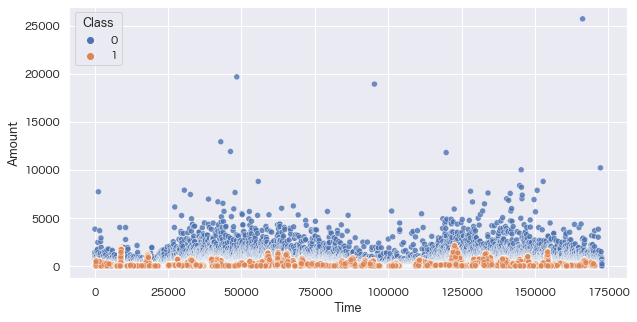

In [21]:
data = over_sampling[['Time', 'Amount', 'Class']]
plt.figure(figsize=[10,5])
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8);

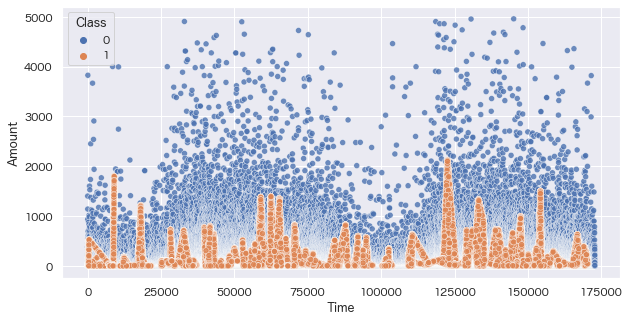

In [22]:
data = over_sampling[over_sampling['Amount']<5000][['Time', 'Amount', 'Class']]
plt.figure(figsize=[10,5])
plt.grid()
sns.scatterplot(data = data, x ='Time', y = 'Amount', hue = 'Class', alpha=0.8);

もともと正例データ(Class=1)は2000以下に分布していたことから、オーバーサンプリング後は2000以下の正例データが量産されていることがわかる。

# 重み付け

誤差関数にクラスの重みを加えて、正例を負例と誤分類した場合のペナルティを重する

In [111]:
def add_weight(weight):
    # データ分割
    X = creditcard.drop('Class',axis=1)
    y = creditcard['Class']
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # ロジスティック回帰
    lr_w = LogisticRegression(max_iter=1000, class_weight=weight)

    lr_w.fit(X_train, y_train)
    y_pred = lr_w.predict(X_test)

    # 混同行列
    matrix = show_confusion_matrix(y_pred, y_test)

    # 評価
    print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('Precision = ', precision_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('Recall = ', recall_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('F1 score = ', f1_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    
    return matrix, lr_w, y_pred, X_train,X_test,y_train,y_test

In [112]:
nega_ratio = 1 / (len(y[y == 0]) / len(y))
posi_ratio = 1 / (len(y[y == 1]) / len(y))
weights=[posi_ratio, nega_ratio] # クラスの割合の逆数

matrix, lr_w, y_pred, X_train,X_test,y_train,y_test = add_weight(weights)
matrix

Accuracy =  0.999
Precision =  0.735
Recall =  0.543
F1 score =  0.625


,予測_負例(0),予測_正例(1)
実際_負例(0),28426,9
実際_正例(1),21,25


クラスの割合の逆数では、重み付けの割合としては、有効ではない

In [113]:
weights = 'balanced' # 重みの自動調整
matrix, lr_w, y_pred, X_train,X_test,y_train,y_test = add_weight(weights)
matrix

Accuracy =  0.966
Precision =  0.04
Recall =  0.87
F1 score =  0.076


,予測_負例(0),予測_正例(1)
実際_負例(0),27472,963
実際_正例(1),6,40


In [27]:
# 「class_weight='balanced'」では、入力データのクラス頻度に反比例する重みを算出している
# 計算式としては、比例の逆数 / クラス数、を求めている
n_samples = len(creditcard['Class']) # 全サンプル数
n_classes = 2 # 全クラス数
np.bincount(y) # 正例・負例件数
# 計算式
weight = n_samples / (n_classes * np.bincount(y))
weight

array([284315,    492])

array([  0.50086524, 289.43800813])

「比例の逆数 / クラス数」の重み付けにより、正例をより多く予測するモデルを構築することができた。  
結果、再現率Recallが上昇し、より多くの正例データを予測することができている。  

# 評価指標

In [117]:
def modeling(data):
    X = data.drop('Class',axis=1)
    y = data['Class']

    # データ分割
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # ロジスティック回帰
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    # 混同行列
    matrix = show_confusion_matrix(y_pred, y_test)
    print(matrix)

    # 評価
    print('Accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('Precision = ', precision_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('Recall = ', recall_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    print('F1 score = ', f1_score(y_true=y_test, y_pred=y_pred).round(decimals=3))
    
    return lr, y_pred, X_train, X_test, y_train, y_test

In [118]:
# アンダーサンプリング
lr, y_pred, X_train, X_test, y_train, y_test = modeling(under_sampling)

         予測_負例(0) 予測_正例(1)
実際_負例(0)       47        4
実際_正例(1)        9       39
Accuracy =  0.869
Precision =  0.907
Recall =  0.812
F1 score =  0.857


In [119]:
# ROC曲線
def plot_roc_curve(pred, y_test):
    pred =  np.where(pred > 0.5, 1, 0.5)
    fpr, tpr, thresholds = metrics.roc_curve(pred, y_test)
    plt.figure(figsize=[15, 5])
    plt.plot(fpr, tpr, label=f'roc_curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid()
    plt.show()

    auc = metrics.auc(fpr, tpr)
    print('auc: {:.3f}'.format(auc));

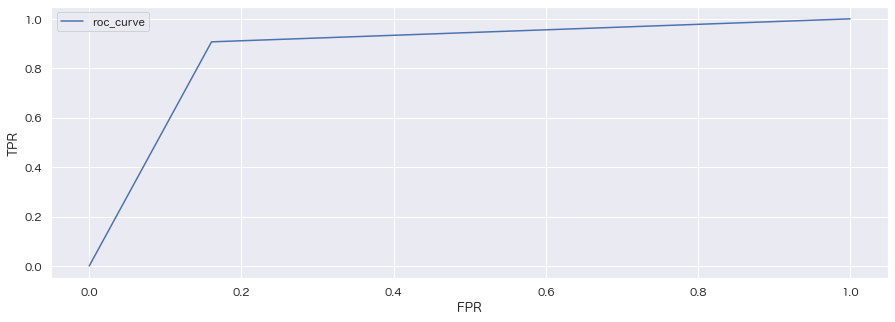

auc: 0.873


In [120]:
plot_roc_curve(y_pred, y_test)

In [121]:
# Precision-Recall曲線
def plot_precision_recall_curve(y_test, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)

    auc = metrics.auc(recall, precision)
    print(f'AUC： {round(auc,3)}%')

    plt.figure(figsize=[15, 5])
    plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show();

AUC： 0.905%


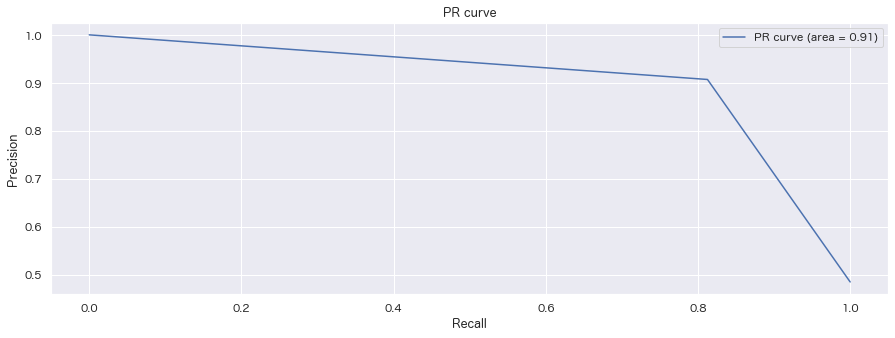

In [122]:
plot_precision_recall_curve(y_test, y_pred)

In [129]:
# 学習曲線
def plot_learning_curve(model, X_data, y_data):
    # データ準備
    train_sizes, train_scores, val_scores = learning_curve(model, X=X_data, y=y_data, train_sizes = np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Traing score と Val score をプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")

    # 標準偏差の範囲を色付け
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.2)

    # Y軸の範囲
    plt.ylim(0.8, 1.0)

    # 凡例の表示位置
    plt.grid()
    plt.legend(loc="best")
    plt.show();

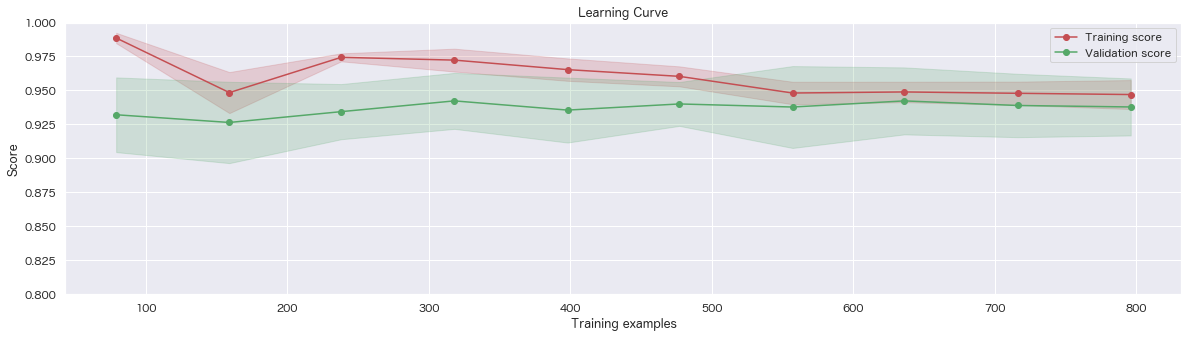

In [130]:
plot_learning_curve(lr, X_train, y_train)

ROC曲線、Precision-Recall曲線をみる限り、まだまだ改善の余地はありそうである。  
学習曲線をみると90%以上で次第にスコアが収束している為、過学習は引き起こしてなさそうである。  

In [132]:
# オーバーサンプリング
lr, y_pred, X_train, X_test, y_train, y_test = modeling(over_sampling)

         予測_負例(0) 予測_正例(1)
実際_負例(0)    27982      517
実際_正例(1)     1004    27360
Accuracy =  0.973
Precision =  0.981
Recall =  0.965
F1 score =  0.973


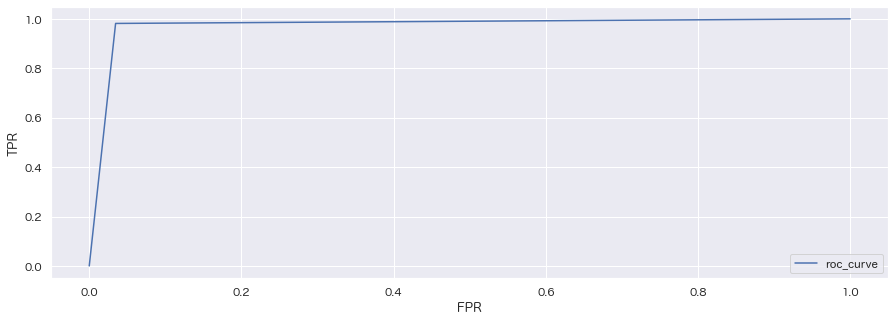

auc: 0.973


In [133]:
plot_roc_curve(y_pred, y_test)

AUC： 0.982%


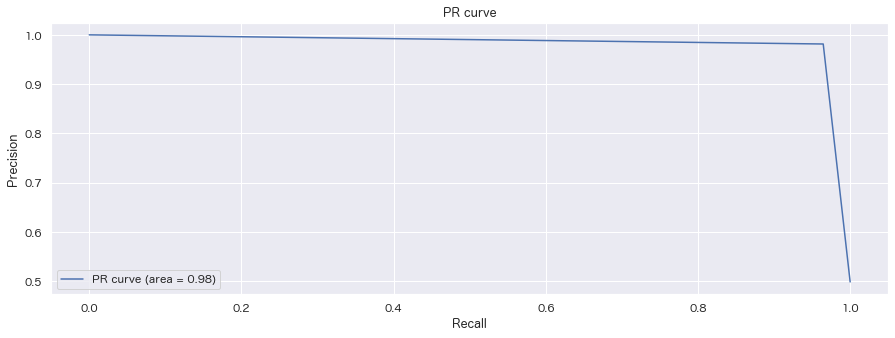

In [134]:
plot_precision_recall_curve(y_test, y_pred)

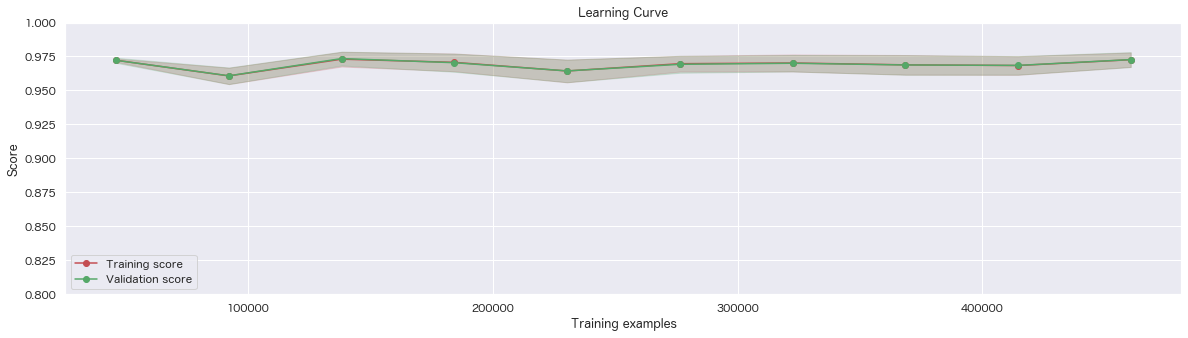

In [135]:
plot_learning_curve(lr, X_train, y_train)

高いスコアが出てはいるが、訓練データと検証データに対しての予測スコアが完全に一致してしまっていることから、訓練データが検証データのパターンを網羅してしまっていると（訓練データと検証データに違いがない）と考えられる。その為、この結果をみる限りでは正しく学習できているかは判断がつけられない。断定はできないが、過学習を引き起こしてしまっている可能性もあると思われる。